# Bike score predictor

**I. Overview**  
  
The objective of this project is to build a model to predict "bikeability" of cities across the United States based on various city features. The use case for this model is a pilot bike and scooter share program looking to expand into a new urban market.  
  
I use OLS regression techniques to predict the target value, urban bike score, which ranges from 0 (poor biking conditions) to 100 (perfect biking conditions). Features for my model include a city's public transit score, population, population density, business density, weather, GDP per capita, and local tax rates. Data sources include Walk Score, U.S. Climate Data, INRIX, City Lab, and the Tax Foundation.  

**II. Data wrangling**  

In [2]:
%pylab inline
%config InlineBackend.figure_formats = ['retina']

import pandas as pd
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV
from sklearn.metrics import r2_score 
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error as mae
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.model_selection import GridSearchCV

from statsmodels.stats.outliers_influence import variance_inflation_factor

import math

def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn
warnings.filterwarnings("ignore", category=DeprecationWarning)

Populating the interactive namespace from numpy and matplotlib


After gathering and cleaning data from the afforementioned sources, I needed to join the information from various sources. One main source of headache was the different naming conventions for the same city (Washington, D.C. and Washington DC, for example). I ran the following function on all datasets to make sure cities with multiple naming conventions (or type-os) were harmonized across datasets.

In [7]:
def fix_cities(df):
    df.loc[df['city'] == 'Nashville', 'city'] = 'Nashville-Davidson'
    df.loc[df['city'] == 'Louisville', 'city'] = 'Louisville-Jefferson'
    df.loc[df['city'] == 'Lexington', 'city'] = 'Lexington-Fayette'    
    df.loc[df['city'] == 'OklahomaCity', 'city'] = 'Oklahoma City'
    df.loc[df['city'] == 'Salt LakeCity', 'city'] = 'Salt Lake City'
    df.loc[df['city'] == 'SanFrancisco', 'city'] = 'San Francisco'
    df.loc[df['city'] == 'VirginiaBeach', 'city'] = 'Virginia Beach'
    df.loc[df['city'] == 'Washington,D.C.', 'city'] = 'Washington, D.C.'
    df.loc[df['city'] == 'Washington Dc', 'city'] = 'Washington, D.C.'
    df.loc[df['city'] == 'Washington', 'city'] = 'Washington, D.C.'
    df.loc[df['city'] == 'New York', 'city'] = 'New York City'

Next, since there are some cities with the same name across different states, I needed to join dataframe on a combination of city and state. However, some datasets included the full state name while others included the two-letter abbrviation only. I created a dictionary to map state names to state abbreviations.

In [10]:
states_abbrev = {'Alaska': 'AK', 'Alabama': 'AL', 'Arkansas': 'AR', 'Arizona': 'AZ',
                 'California': 'CA', 'Colorado': 'CO', 'Connecticut': 'CT',
                 'District of Columbia': 'DC','Delaware': 'DE','Florida': 'FL','Georgia': 'GA',
                 'Hawaii': 'HI','Iowa': 'IA', 'Idaho': 'ID', 'Illinois': 'IL', 'Indiana': 'IN',
                 'Kansas': 'KS', 'Kentucky': 'KY', 'Louisiana': 'LA', 'Massachusetts': 'MA',
                 'Maryland': 'MD', 'Maine': 'ME', 'Michigan': 'MI', 'Minnesota': 'MN',
                 'Missouri': 'MO', 'Mississippi': 'MS', 'Montana': 'MT', 'North Carolina': 'NC',
                 'North Dakota': 'ND', 'Nebraska': 'NE', 'New Hampshire': 'NH', 'New Jersey': 'NJ',
                 'New Mexico': 'NM', 'Nevada': 'NV', 'New York': 'NY', 'Ohio': 'OH',
                 'Oklahoma': 'OK', 'Oregon': 'OR', 'Pennsylvania': 'PA', 'Puerto Rico': 'PR',
                 'Rhode Island': 'RI', 'South Carolina': 'SC', 'South Dakota': 'SD', 'Tennessee': 'TN',
                 'Texas': 'TX', 'Utah': 'UT', 'Virginia': 'VA', 'Vermont': 'VT',
                 'Washington': 'WA', 'Wisconsin': 'WI', 'West Virginia': 'WV', 'Wyoming': 'WY'}

I had previously "pickled" each individual dataframe, so my next step was to read in each pickle, make sure city names and states were harmonized, and merge accross city and state.

In [47]:
df = pd.read_pickle('city_traffic.pkl')
df['city'] = df['city'].str.lower()
df['state'] = df['state'].str.strip()
df['city'] = df['city'].str.strip()
fix_cities(df)

In [48]:
files = ['city_busdensity.pkl','city_percip.pkl','city_poulations.pkl',
         'city_taxes.pkl','city_temp.pkl','city_walkscore.pkl']

In [49]:
for file in files:
    df_pkl = pd.read_pickle(file)
    if 'city' in df_pkl.columns:
        df_pkl['city'] = df_pkl['city'].str.strip() # Remove leading/trailing white space
        df_pkl['city'] = df_pkl['city'].str.lower() # All names to lowercase
    if 'state_long' in df_pkl.columns:
        df_pkl['state'] = df_pkl['state_long'].map(states_abbrev) #Get state abreviation for these
    df_pkl['state'] = df_pkl['state'].str.strip()
    fix_cities(df)
    if 'state' in df_pkl.columns:
        df = pd.merge(df, df_pkl, on = ['city','state'], how = 'outer')
        print(file,'success')
    else:
        print(file, 'no state column')

city_busdensity.pkl success
city_percip.pkl success
city_poulations.pkl success
city_taxes.pkl success
city_temp.pkl success
city_walkscore.pkl success


Great! Now I have one master dataset to pickle for later when I'm ready to start my exploratory data analysis (EDA) and feature engineering.

In [52]:
df.to_pickle('city_data.pkl')

**III. EDA and feature engineering**

In [128]:
df = pd.read_pickle('city_data.pkl')

First, I kept only my target value (bike score) and features in the dataframe.

In [129]:
df = df[['bike_score','walk_score','transit_score',
         'congestion', 'bus_density','pop_density', 'population', 
         'gdp_per_cap',  'state_tax', 'city_tax', 'total_tax',
         'avg_percip',  'avg_temp']]

In [130]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 293 entries, 0 to 1553
Data columns (total 13 columns):
bike_score       293 non-null float64
walk_score       293 non-null float64
transit_score    293 non-null float64
congestion       293 non-null float64
bus_density      293 non-null float64
pop_density      293 non-null float64
population       293 non-null float64
gdp_per_cap      293 non-null float64
state_tax        293 non-null float64
city_tax         293 non-null float64
total_tax        293 non-null float64
avg_percip       293 non-null float64
avg_temp         293 non-null float64
dtypes: float64(13)
memory usage: 32.0 KB


In [131]:
df.describe()

,bike_score,walk_score,transit_score,congestion,bus_density,pop_density,population,gdp_per_cap,state_tax,city_tax,total_tax,avg_percip,avg_temp
count,293.000000,293.000000,293.000000,293.000000,293.000000,293.000000,2.930000e+02,293.000000,293.000000,293.000000,293.000000,293.000000,293.000000
mean,45.052362,43.773282,33.614184,0.055017,30.161538,1628.000000,2.183454e+05,45301.423208,0.058409,0.019637,0.076972,37.755890,58.111765
std,11.328355,13.145953,8.700270,0.025810,4.297794,915.234228,3.579838e+05,12172.601778,0.009962,0.008182,0.006260,12.618401,7.524197
min,17.000000,14.000000,0.000000,0.010000,16.500000,341.000000,1.714000e+04,20509.000000,0.029000,0.000000,0.045000,4.200000,38.900000
25%,38.100000,35.000000,33.000000,0.040000,30.161538,1628.000000,6.213400e+04,37614.000000,0.056000,0.019637,0.076972,34.440000,52.400000
50%,45.052362,42.700000,33.614184,0.050000,30.161538,1628.000000,1.159420e+05,42349.000000,0.060000,0.019637,0.076972,37.755890,58.111765
75%,50.000000,50.000000,33.614184,0.070000,30.161538,1628.000000,2.183454e+05,52270.000000,0.062500,0.019637,0.076972,46.150000,62.300000
max,90.000000,86.000000,80.400000,0.140000,79.000000,11056.000000,3.792621e+06,89978.000000,0.075000,0.060000,0.102500,66.220000,77.600000


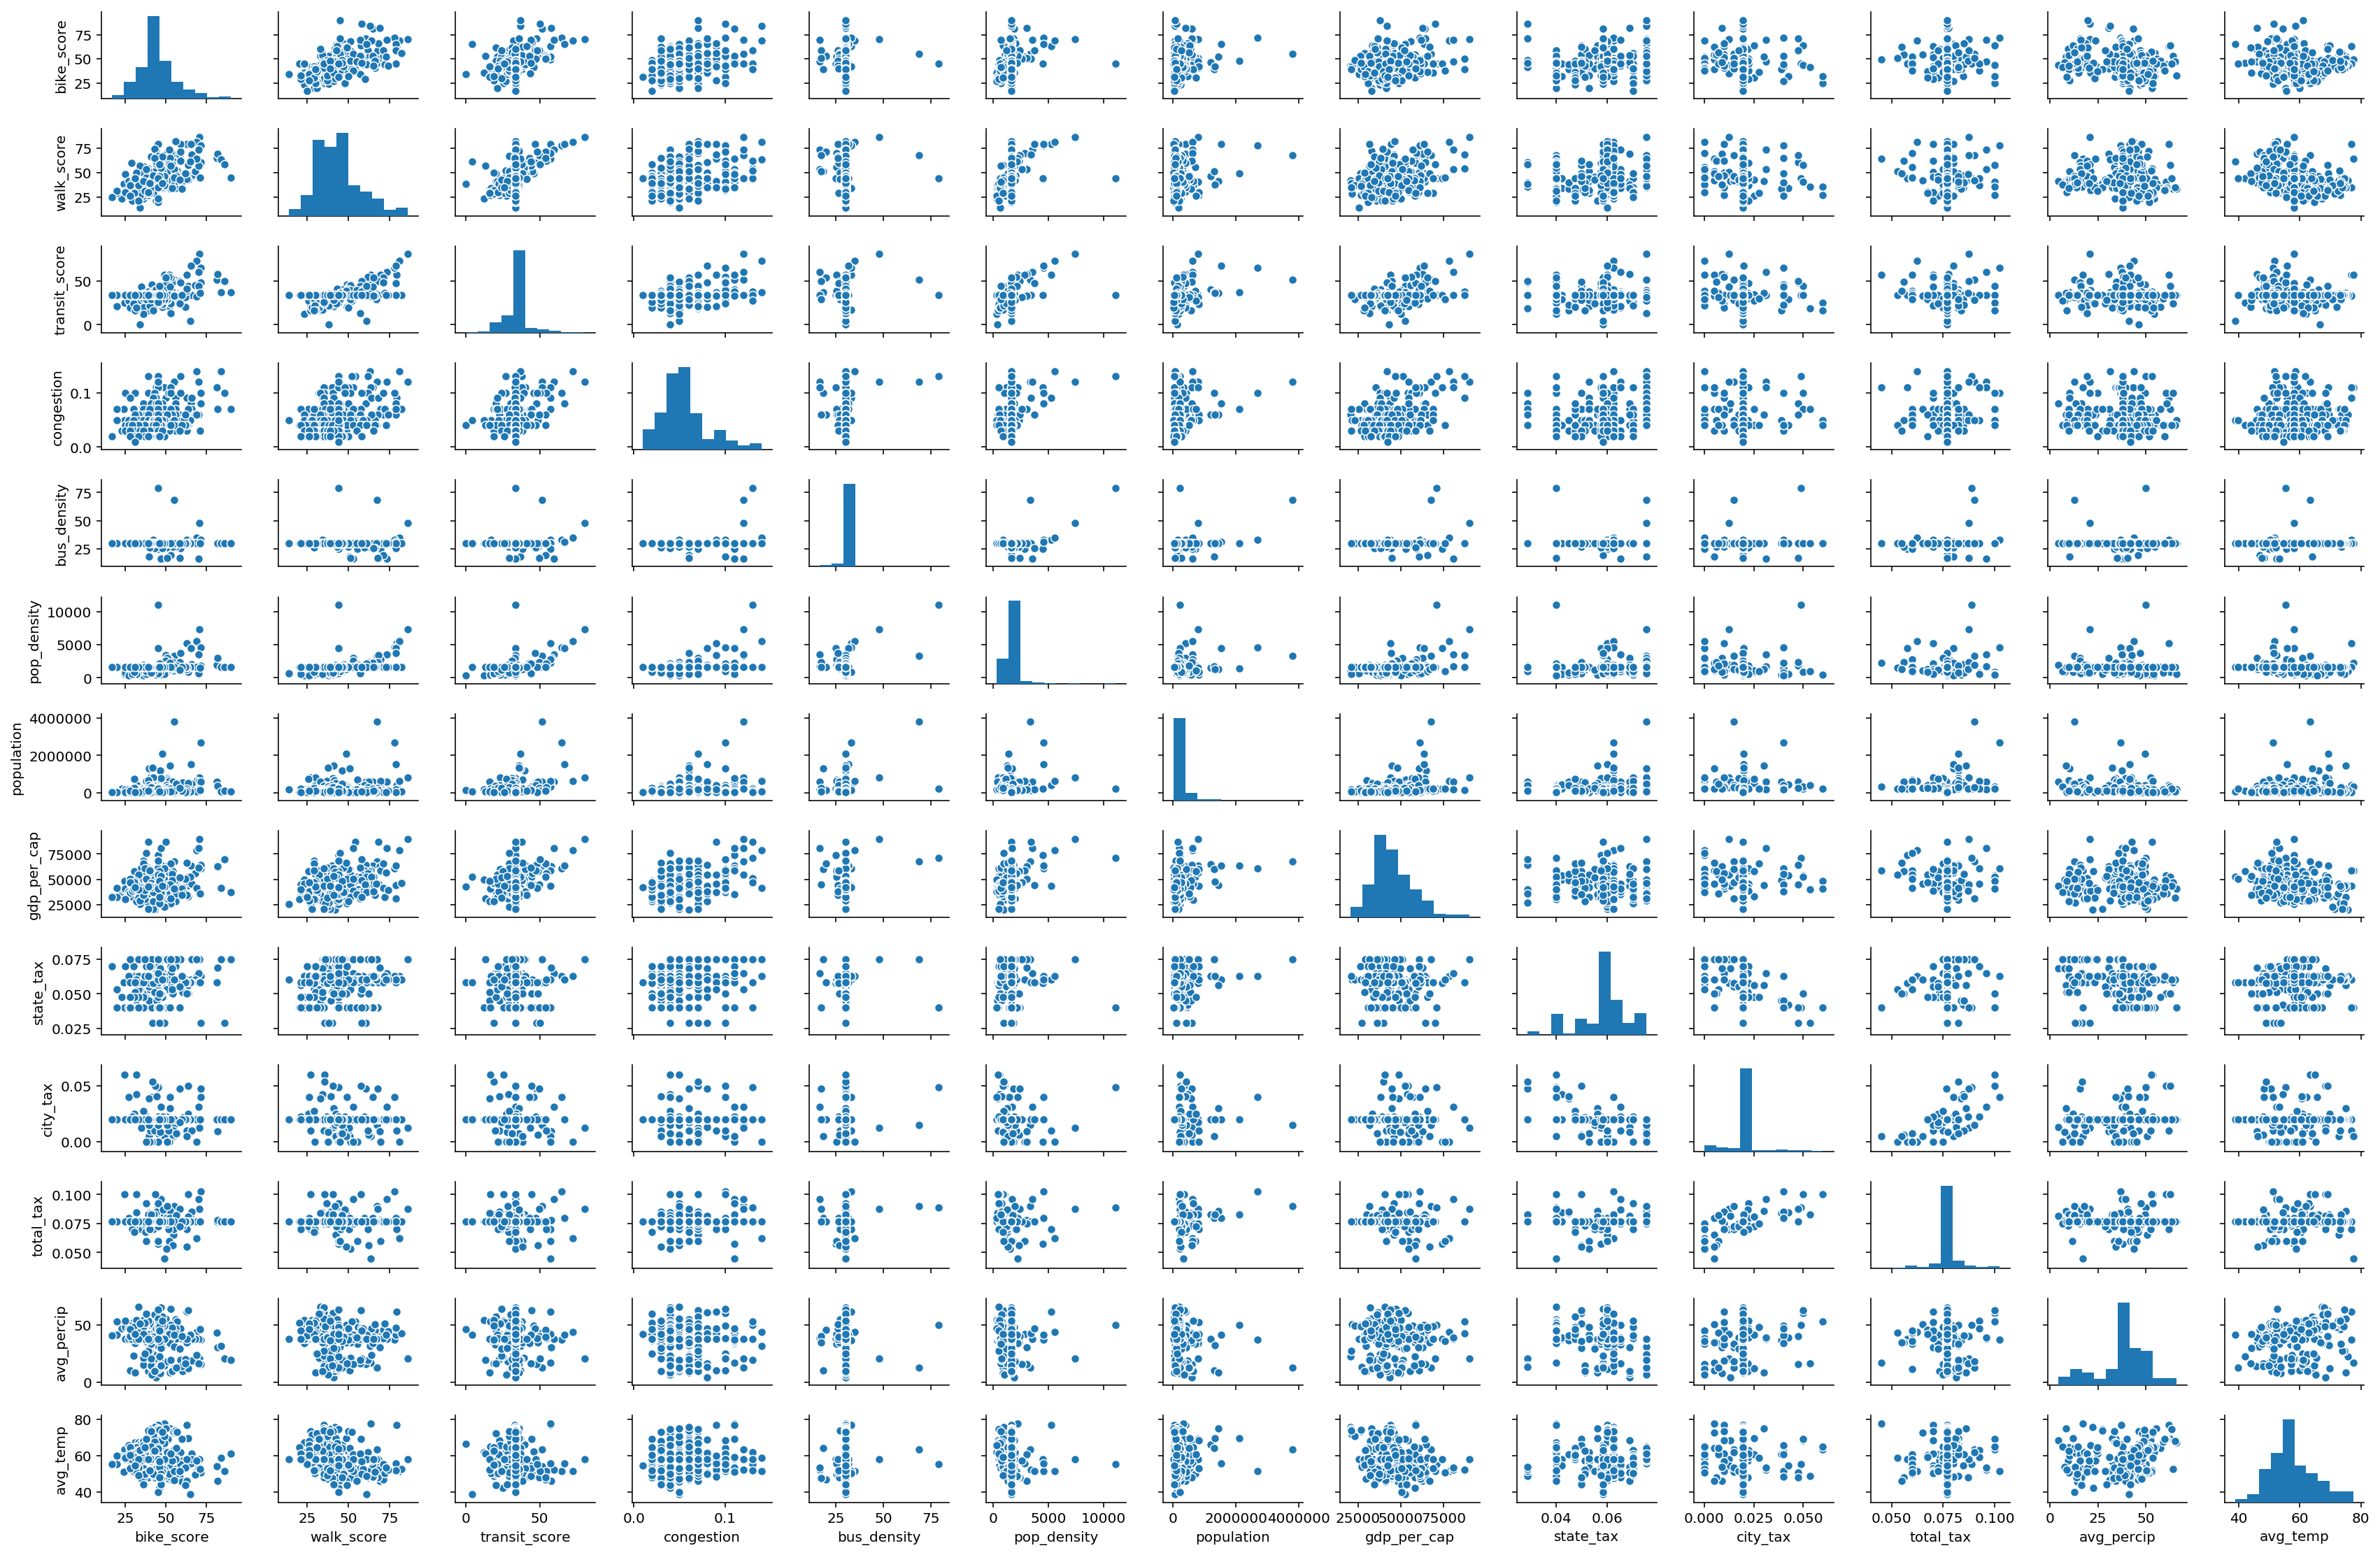

In [65]:
sns.pairplot(df, height=1.2, aspect=1.5);

While most features seem to be normally distributed, population, population density ('pop_density'), and business density ('bus_density') are notable exceptions that might benefit from a log transformation.

In [133]:
log_vars = ['population','pop_density','bus_density']
for v in log_vars:
    df['log_'+v] = log(df[v])

As can be seen from the histograms before, the distribution of population looks far more normal after the log transformation. 

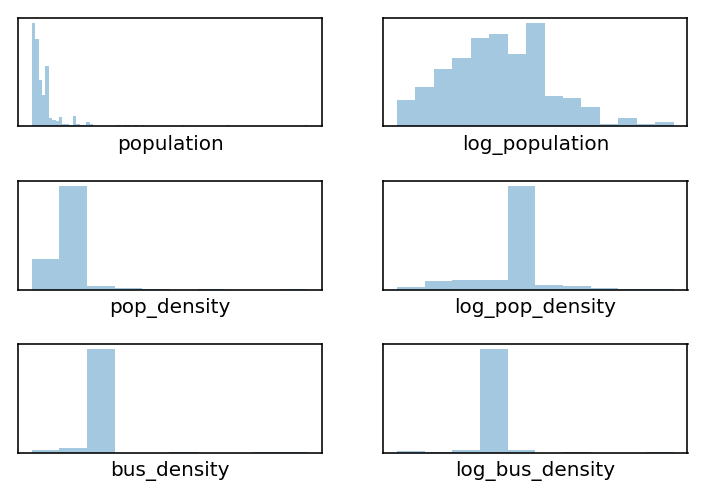

In [70]:
f, axes = plt.subplots(3, 2)
f.subplots_adjust(hspace = 0.5)
sns.distplot(df.population, ax=axes[0][0], kde=False, bins='auto')
sns.distplot(df.log_population, ax=axes[0][1], kde=False, bins='auto')
sns.distplot(df.pop_density, ax=axes[1][0], kde=False, bins='auto')
sns.distplot(df.log_pop_density, ax=axes[1][1], kde=False, bins='auto')
sns.distplot(df.bus_density, ax=axes[2][0], kde=False, bins='auto')
sns.distplot(df.log_bus_density, ax=axes[2][1], kde=False, bins='auto')

for i in range(0,3):
    for j in range(0,2):
        axes[i][j].set_xticks([])
        axes[i][j].set_yticks([])

Population and business density, on the other hand, are not more normalized. Rather, it seems that these features have large outliers (for example, New York City) that are causing them to skew left. Nonetheless, the relationship between the transformed density features and the target value appear more linear after the log transformation, so I will leave them and see if they are in fact significant.

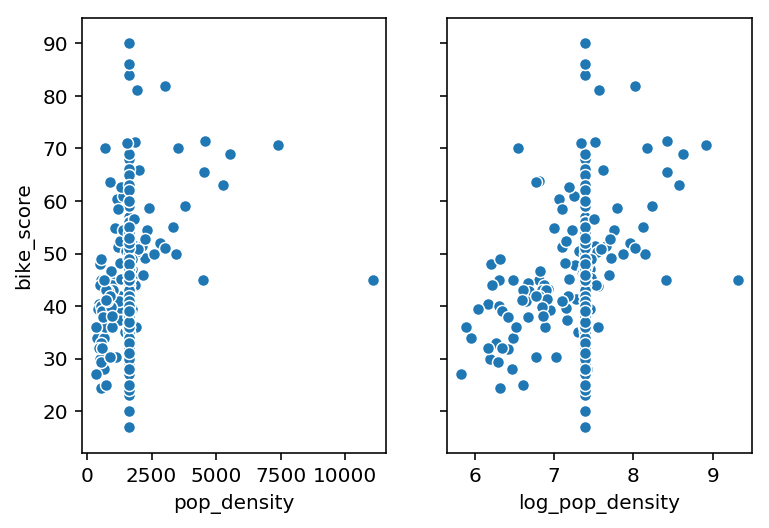

In [98]:
fig, (ax1,ax2) = plt.subplots(ncols=2, sharey=True)
sns.scatterplot(x=df['pop_density'],y=df['bike_score'], ax=ax1)
sns.scatterplot(x=df['log_pop_density'],y=df['bike_score'], ax=ax2)

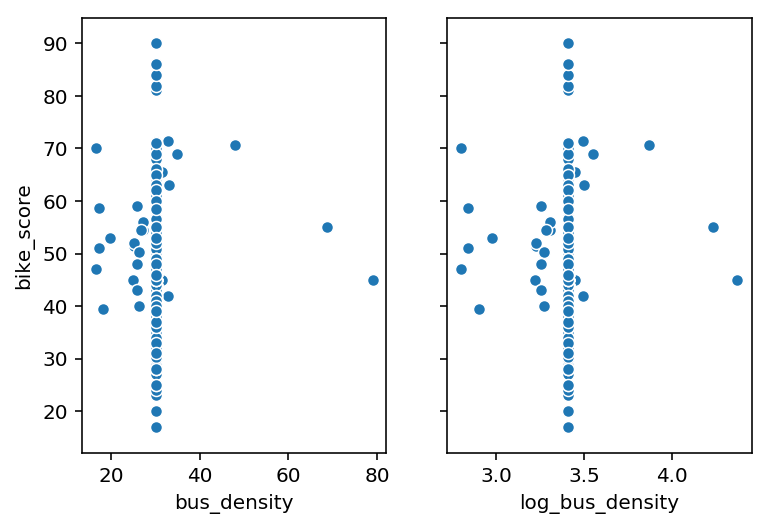

In [99]:
fig, (ax1,ax2) = plt.subplots(ncols=2, sharey=True)
sns.scatterplot(x=df['bus_density'],y=df['bike_score'], ax=ax1)
sns.scatterplot(x=df['log_bus_density'],y=df['bike_score'], ax=ax2)

Next, I explored correlations among my features to account for any colinearity.

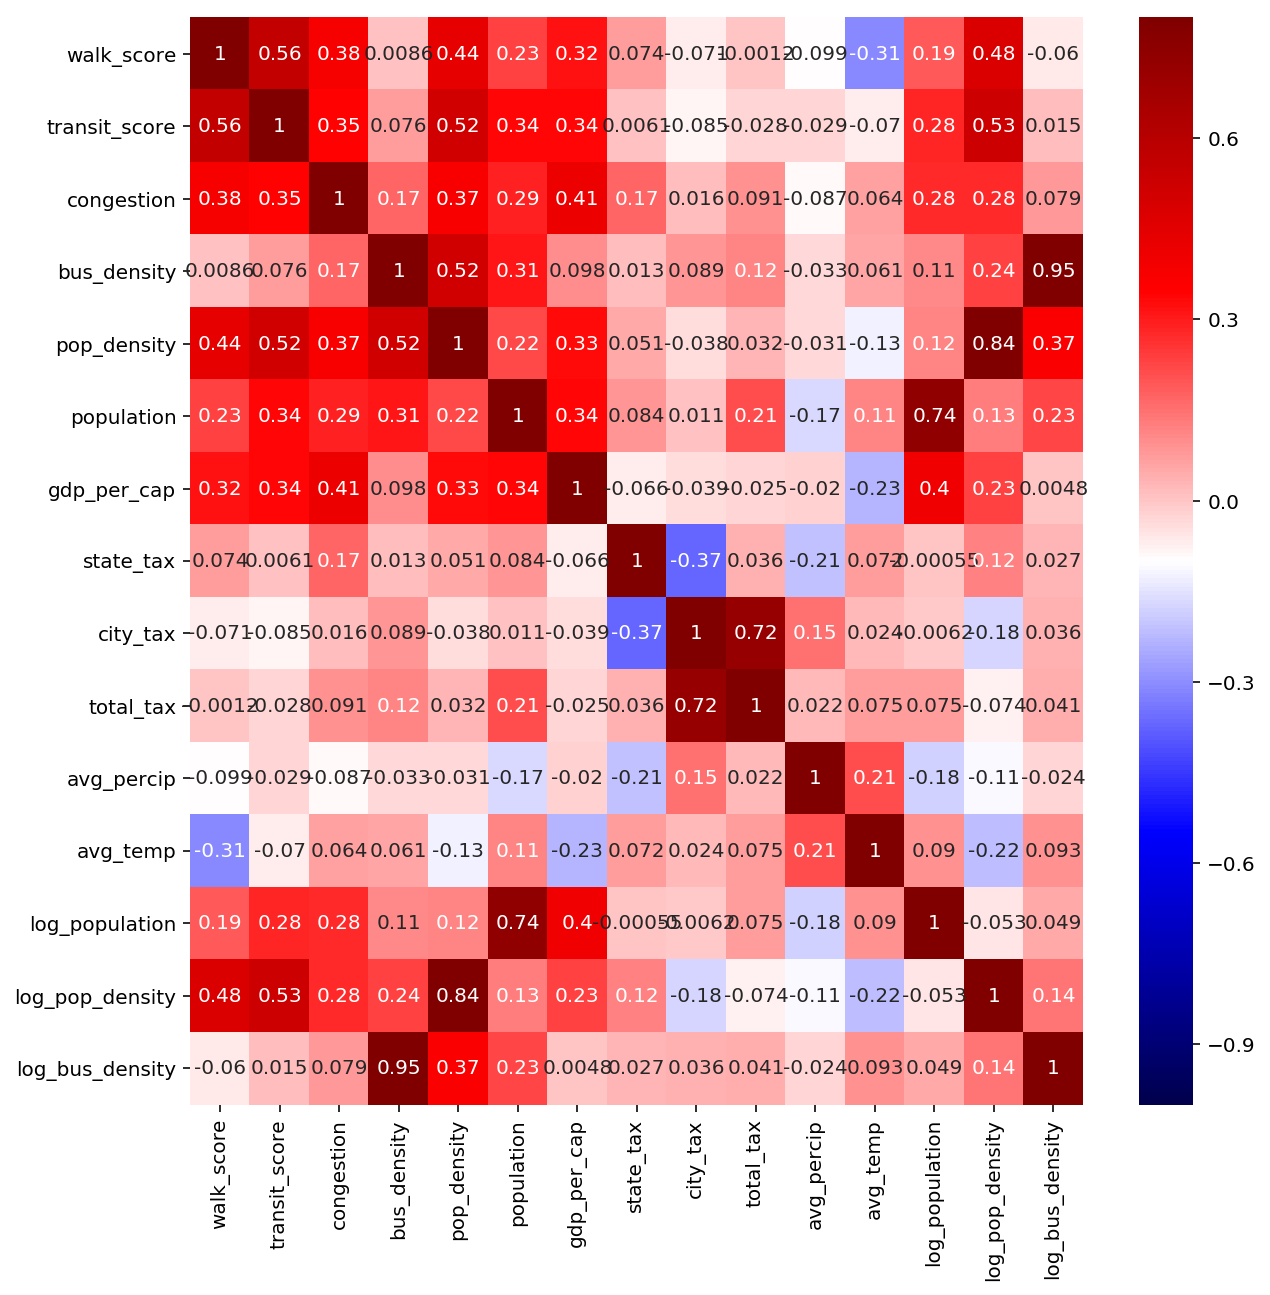

In [103]:
fig, ax = plt.subplots(figsize=(10,10)) 
sns.heatmap(df.iloc[:,1:].corr(), cmap="seismic", annot=True, vmin=-1, vmax=.8, ax=ax);

In [134]:
corrs = {}
cols = list(df.iloc[:,1:].columns)
for x in cols:
    cols = [w for w in cols if w != x]
    for w in cols:
        corrs[(x, w)] = df[x].corr(df[w])
results = [(x, v.round(2)) for x, v in corrs.items() if corrs[x] > 0.5]

results = sorted(results, key=lambda x: x[1], reverse=True)
results

[(('bus_density', 'log_bus_density'), 0.95),
 (('pop_density', 'log_pop_density'), 0.84),
 (('population', 'log_population'), 0.74),
 (('city_tax', 'total_tax'), 0.72),
 (('walk_score', 'transit_score'), 0.56),
 (('transit_score', 'log_pop_density'), 0.53),
 (('transit_score', 'pop_density'), 0.52),
 (('bus_density', 'pop_density'), 0.52)]

The first three correlations are expected (the log of a variable should be highly correlated with the variable itself). Total tax was simply the sum of city and state taxes, so I will have to choose one or the other feature to include in the model. The bottom four pairs of features with correlations between 0.52 and 0.56 might be of concern later. I will create interaction terms for these.

In [135]:
interact = [x[0] for x in results[4:]]
interact

[('walk_score', 'transit_score'),
 ('transit_score', 'log_pop_density'),
 ('transit_score', 'pop_density'),
 ('bus_density', 'pop_density')]

In [136]:
interacts = []
for i in range(len(interact)):    
    col1 = interact[i][0]
    col2 = interact[i][1]
    col_interact = col1+'_x_'+col2
    interacts.append(col_interact)
    df[col_interact] = df[col1]*df[col2]
interacts

['walk_score_x_transit_score',
 'transit_score_x_log_pop_density',
 'transit_score_x_pop_density',
 'bus_density_x_pop_density']

Next, I check variance inflation factors of various combinations of features to make sure any colinearity among my final features is low.

In [151]:
df['constant'] = 1
X = df[['congestion', 'population', 'gdp_per_cap', 'walk_score_x_transit_score',
       'total_tax', 'avg_percip', 'avg_temp', 'log_population',       
       'bus_density_x_pop_density', 'constant']]
vif = pd.Series([variance_inflation_factor(X.values, i) for i in range(X.shape[1])], 
                index=X.columns)
vif.sort_values(ascending = False)

constant                      583.346257
population                      2.543732
log_population                  2.454660
gdp_per_cap                     1.617736
walk_score_x_transit_score      1.553450
congestion                      1.489778
avg_temp                        1.320837
bus_density_x_pop_density       1.210152
avg_percip                      1.144017
total_tax                       1.094508
dtype: float64

Now that I have my data ready to go for analysis, I will pickle this version of the dataframe before continuing to hpyterparameter tuning and model selection.

In [152]:
df.to_pickle('regression_data.pkl')

**IV. Hypterparameter tuning and model selection**

Finally, I am ready to create my model and see which features determine bikability in a city.

In [3]:
df = pd.read_pickle('regression_data.pkl')

First, I define y as my target variable (bike score) and X as a matrix of my features.

In [4]:
y = df['bike_score']
X = df[['congestion', 'transit_score', 'gdp_per_cap', 
       'total_tax', 'avg_percip', 'avg_temp', 'log_population',       
       'bus_density_x_pop_density']]

Next, I split my data into training and testing sets. I will train my model on 80% of the data and reserve 20% for testing.

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
                                                random_state = 88)


**a. Linear regression**

First, I fit a regular linear regression model on 5 cross-validation folds of data (meaning that one-fifth of my data was always being held out for validating my scoring metric). I got an average mean absolute error (MAE) of close to 8 across all validation folds. On the test data, the MAE does improve, to 7.26.

In [6]:
lr=LinearRegression(fit_intercept=True)

scores = cross_val_score(lr, X_train, y_train, cv = 5, scoring='neg_mean_absolute_error')
print (np.mean(scores)*(-1))


7.951647435626477


In [9]:
model = lr.fit(X_train, y_train)
y_pred = model.predict(X_test)
mae(y_pred, y_test)

7.260353506035569

**b. Ridge regression**

In [43]:
std_scale = StandardScaler()
X_train_scaled = std_scale.fit_transform(X_train)
X_test_scaled = std_scale.transform(X_test)

I know that there was a significant amount of multicolinearity with my features, so next I tried a ridge regression which will add a penalization for multicolinearity.

In [45]:
ridge = Ridge(random_state=88)

I use GridSearchCV from sklearn to find the alpha parameter that will give me the best average mean absolute error across five cross-validation folds.

In [46]:
grid_r1 = {'alpha': np.array([100,75,50,25,10,1,0.1,0.01,0.001,0.0001,0])}
ridge_grid = GridSearchCV(ridge, grid_r1, cv=5, scoring='neg_mean_absolute_error')
ridge_grid.fit(X_train_scaled, y_train)

print("tuned hpyerparameters :(best parameters) ",ridge_grid.best_params_)
print("MAE score :",-1*(ridge_grid.best_score_))

tuned hpyerparameters :(best parameters)  {'alpha': 100.0}
MAE score : 7.518907289091638


The best alpha was 100, which gave a slight impovement in MAE from the regular linear regression performance on the training data set.

Next, I fit this optimal model on my entire test data, and use it to predict y-values for my training data (remember that 20% that we put to the side?). I actually get an improvement in my mae on the testing data--the model is able to predict bike scores within 6.9 points of the actual value.

In [49]:
ridge = Ridge(random_state=88, alpha=100)
rm = ridge.fit(X_train_scaled, y_train)
y_pred = rm.predict(X_test_scaled)
mae(y_pred, y_test)

6.906067063078532

**c. Lasso regularization**

Lasso regularization penalizes for multicolinearity, and keeps only significant features with non-zero coefficiens. Given this, I decided to throw the "kitchen sink" of features into this model.

In [74]:
y = df['bike_score']
XL = df.drop(['bike_score','constant'], axis=1)

In [75]:
X_train, X_test, y_train, y_test = train_test_split(XL, y, test_size=0.2, 
                                                random_state = 88)

std_scale = StandardScaler()
X_train_scaled = std_scale.fit_transform(X_train)
X_test_scaled = std_scale.transform(X_test)

Once again, my first step was to gridsearch for the optimal alpha. An alpha of 1.0 returned an MAE of 6.6, so already this was an improvement from the ridge model.

In [76]:
grid_l1 = {'alpha': np.array([100,75,50,25,10,1,0.1,0.01,0.001,0.0001,0])}
lasso = Lasso(random_state=88)
lasso_grid = GridSearchCV(lasso, grid_l1, cv=5, scoring='neg_mean_absolute_error')
lasso_grid.fit(X_train_scaled, y_train)

print("tuned hpyerparameters :(best parameters) ",lasso_grid.best_params_)
print("MAE score :",-1*(lasso_grid.best_score_))

tuned hpyerparameters :(best parameters)  {'alpha': 1.0}
MAE score : 6.609809389765507


Using alpha of 1.0, I fit the model on the training data, and then ran predictions on the test data. MAE for the test data was reduced even further, to 6.1. Not bad!

In [77]:
lasso = Lasso(random_state=88, alpha=1.0, fit_intercept=True)

In [78]:
lm = lasso.fit(X_train_scaled, y_train)
y_pred = lm.predict(X_test_scaled)
mae(y_pred, y_test)

6.10212552832352

As I mentioned previously, lasso regularization tends to take several feature coefficients to zero and keep only a select set of significant features. Indeed, only walk score, walk score/transit score interaction, congestion, and average percipitation have non-zero coefficients. I decided to keep all but walk score in the final model.

In [57]:
coefficients = sorted(list(zip(X_test.columns, lm.coef_.round(2))), key=lambda x: x[1], reverse=True)
coefficients

[('walk_score', 3.88),
 ('walk_score_x_transit_score', 1.61),
 ('congestion', 0.82),
 ('transit_score', 0.0),
 ('bus_density', -0.0),
 ('pop_density', 0.0),
 ('population', 0.0),
 ('gdp_per_cap', 0.0),
 ('state_tax', 0.0),
 ('city_tax', -0.0),
 ('total_tax', -0.0),
 ('avg_temp', -0.0),
 ('log_population', 0.0),
 ('log_pop_density', 0.0),
 ('log_bus_density', -0.0),
 ('transit_score_x_log_pop_density', 0.0),
 ('transit_score_x_pop_density', 0.0),
 ('bus_density_x_pop_density', 0.0),
 ('avg_percip', -0.99)]

Below is the code for my final model that fits on a subset of the training data with the three significant columns and returns a final MAE metric of 6.3 on the test data.

In [79]:
y = df['bike_score']
XL2 = df[['walk_score_x_transit_score','congestion','avg_percip']]

X_train, X_test, y_train, y_test = train_test_split(XL2, y, test_size=0.2, 
                                                random_state = 88)

std_scale = StandardScaler()
X_train_scaled = std_scale.fit_transform(X_train)
X_test_scaled = std_scale.transform(X_test)

lm2 = lasso.fit(X_train_scaled, y_train)
y_pred = lm2.predict(X_test_scaled)
mae(y_pred, y_test)

6.2582423784235415

**Results**

Based on the model coefficients, it seems that more bikable cities are those with a precedent for alternative modes of transit (public transit and walking), more congestion (greater incentive to find an alternative mode to private vehicles), and less precipitation (rain/snow).

In [80]:
coefficients = sorted(list(zip(X_test.columns, lm2.coef_.round(2))), key=lambda x: x[1], reverse=True)
coefficients

[('walk_score_x_transit_score', 4.96),
 ('congestion', 0.79),
 ('avg_percip', -1.33)]

The low R-squared and adjusted R-squared of my model suggest that much of the variance of a city's bikability is not explained by my selected features. A next step will be to gather additional features that migh explain bikability, such as the quality of bike-related infrastructure and overall hilliness.

In [62]:
def r2_adj(X,Y,r_squared):
    adjusted_r_squared = 1 - (1-r_squared)*(len(y)-1)/(len(y)-X.shape[1]-1)
    return(adjusted_r_squared)

In [63]:
r2 = lm2.score(X_test_scaled, y_test)
r2a = r2_adj(X_test_scaled, y_test, r2)
print('R-squared', r2.round(2), 'Adjusted r-squared', r2a.round(2))

R-squared 0.36 Adjusted r-squared 0.36


Once the model is refined and the mean absolute error is reduced, the next step will be to include international cities for which walkscore.com does not currently have bike scores readily available. With urbanization increasing worldwide and the threat of climate change looming over us, it is imperative that cities find ways to reduce private vehicle congestion and emissions. Bike and scooter share programs can contribute to this endeavor and it is my hope that this project will shed some light on those factors that determine viable pre-conditions for  implementation of such programs.

***